## Virtual Environment for Individual-Based Modeling

### Advanced Project I

Created on March 31, 2019 by Ralph Florent <r.florent@jacobs-university.de>

#### Description
WIP...

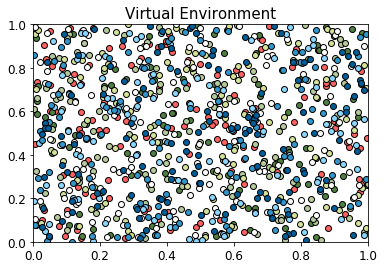

In [3]:
""" Individual-Based Modeling """

# -*- coding: utf-8 -*-
# 
# Created on March 31, 2019
# Authors: 
#        Ralph Florent <r.florent@jacobs-university.de>

### START: scripts

# Import relevant libraries
import matplotlib.pyplot as plt
import numpy as np

# define environmental agents:
# 1) lagoon depth: 5cm, 25cm, 50cm
# 2) landscape: human settlement, vegetation, national park, soil, sea
TOTAL_AGENTS = 1000
ENV_FACTOR_NAMES  = ('HUMAN', 'VEGETATION', 'PARK', 'SOIL', 'SEA', 'LAGOON_5', 'LAGOON_25', 'LAGOON_50')

ENV_FACTOR_COLORS = {
    'HUMAN'     : '#ff6060',
    'VEGETATION': '#507f42',
    'PARK'      : '#b5c99b',
    'SOIL'      : '#d3e298',
    'SEA'       : '#ffffff',
    'LAGOON_5'  : '#89d7ff',
    'LAGOON_25' : '#3097cc',
    'LAGOON_50' : '#005f9b',
}

class Agent:
    pass

# define agents
def initialize(area):
    global agents
    agents = []
    
    for i in range(TOTAL_AGENTS):
        agent = Agent()
        # define restricted area
        agent.x = np.random.random() 
        agent.y = np.random.random()
        agents.append(agent) # append (i.e. add) the ith agent into the array ’agents’
        
# observe the 1st plot
def observe():
    global agents
    plt.cla() # clear axes
    
    for name in AGENT_NAMES:
        grouped = [ag for ag in agents if ag.type == name]
        plt.plot([ag.x for ag in grouped], [ag.y for ag in grouped], 'o', mfc=AGENT_COLORS[name], mec='k')
    
    plt.axis([0, 1, 0, 1])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Virtual Environment', fontsize=15)
        
initialize()
observe()


### END: scripts

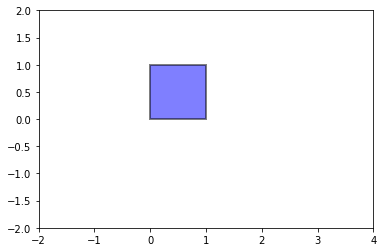

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
#from matplotlib.patches import Rectangle

from matplotlib.path import Path
import matplotlib.patches as Patches #https://matplotlib.org/users/path_tutorial.html

# Number of patches
TOTAL_PATCHES = 2


def create_patches(n=TOTAL_PATCHES, allow_overlap=True):
    """ Create a set patches within a specific area 
    ref: https://matplotlib.org/gallery/statistics/errorbars_and_boxes.html#sphx-glr-gallery-statistics-errorbars-and-boxes-py
    """
    patches = []
    
    verts = [
        (0., 0.), # left, bottom
        (0., 1.), # left, top
        (1., 1.), # right, top
        (1., 0.), # right, bottom
        (0., 0.), # ignored
    ]
    
    codes = [
        Path.MOVETO, # start designing here
        Path.LINETO, # draw lines
        Path.LINETO, # ~
        Path.LINETO, # draw lines
        Path.CLOSEPOLY,# finish here
    ]
    
    path = Path(verts, codes)
    patch = Patches.PathPatch(path, facecolor='b', alpha=0.5, lw=2)
    patches.append(patch)
    
    return patches

def is_restricted_patch(patch, point=()):
    path = patch.get_path()
    return path.contains_points(point)
        
def plot_patches(patches):
    # Create and plot figure 
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    for p in patches:
        ax.add_patch(p)
        
    ax.set_xlim(-2, 4)
    ax.set_ylim(-2, 2)
    plt.show()
        
# create patches 
created_patches = create_patches()
plot_patches(created_patches)
    
